In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warning
warning.filter_warning('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import torchvision
import torchvision.transforms as transforms

In [5]:
BATCH_SIZE = 64

transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 88402720.92it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 37997394.55it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28060338.78it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13084154.37it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


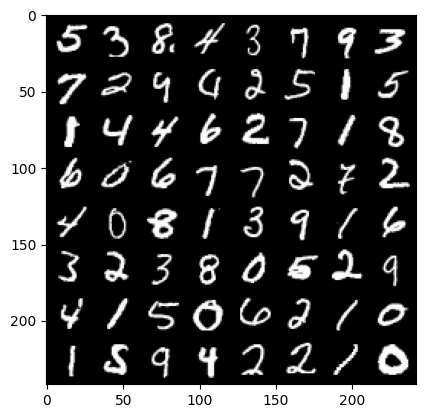

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [8]:
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [9]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super().__init__()

        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.basic_rnn = nn.RNN( n_inputs, n_neurons)
        self.FC = nn.Linear( n_neurons, n_outputs)

    def init_hidden(self,):
        return (torch.zeros(1, self.batch_size, self.n_neurons))

    def forward(self, X):
        X = X.permute(1, 0, 2)
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        out, _ = self.basic_rnn(X,self.hidden)
        out=self.FC(out[-1])
        return out
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)

In [10]:
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)
def get_accuracy(logit, target, batch_size):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [11]:
for epoch in range(N_EPHOCS):  
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()

    for i, data in enumerate(trainloader):
        model.hidden = model.init_hidden()

        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.to(device)
        inputs = inputs.view(-1, 28,28)

        outputs=model(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)

    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f'
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.6478 | Train Accuracy: 79.05
Epoch:  1 | Loss: 0.2943 | Train Accuracy: 91.59
Epoch:  2 | Loss: 0.2323 | Train Accuracy: 93.32
Epoch:  3 | Loss: 0.1932 | Train Accuracy: 94.49
Epoch:  4 | Loss: 0.1732 | Train Accuracy: 95.05
Epoch:  5 | Loss: 0.1560 | Train Accuracy: 95.55
Epoch:  6 | Loss: 0.1468 | Train Accuracy: 95.90
Epoch:  7 | Loss: 0.1379 | Train Accuracy: 96.13
Epoch:  8 | Loss: 0.1205 | Train Accuracy: 96.62
Epoch:  9 | Loss: 0.1200 | Train Accuracy: 96.73


In [12]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)
    inputs=inputs.to(device)
    labels=labels.to(device)
    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 97.21
